# Analyse SA results

Extract w Sobol indices from Dakota's summary.out file and plot.

In [118]:
import pandas as pd
import seaborn as sns
import re

Run with `dakota -i sa_lt.in > sa_summary.out`: only `>` gets results written to file.

In [119]:
# Must be am easier way to get Dakota results out? Apparently not
# Read in .out file (contains summary results)
output_files = ["sa_lt_summary.out", "sa_lt_max_net_elec_summary.out"]

# Match line in output
# w results section
w_results_re = re.compile(
    r"w Sobol' indices:\n\s+Main\s+Total\n((\s+(?:-?\d\.?\d*e[+-]\d+)\s+(?:-?\d\.?\d*e[+-]\d+)\s+(?:\w+)\n)+)"
)
# Line of Sobol indices data
sobols_line_re = re.compile(r"\s+(-?\d\.?\d*e[+-]\d+)\s+(-?\d\.?\d*e[+-]\d+)\s+(\w+)")
results = {
    "design": [],
    "descriptor": [],
    "latex_descriptor": [],
    "main": [],
    "total": [],
}

param_latex = {
    "fdene": r"$f^{max}_{GW}$",
    "hfact": r"$H_{98, y2}$",
    "coreradius": r"$\rho_{core}$",
    "fimp_2": r"$f_{imp, He}$",
    "fimp_14": r"$f_{imp, W}$",
    "psepbqarmax": r"$\frac{P_{sep}B_T}{qAR_0}^{max}$",
    "flhthresh": r"$f^{min}_{LH}$",
    "cboot": r"$c_{BS}$",
    "peakfactrad": r"$\tau^{max}_{rad}$",
    "kappa": r"$\kappa_{sep}$",
    "etaech": r"$n_{ECRH}$",
    "feffcd": r"$f_{CD}$",
    "etath": r"$\eta_{th}$",
    "etaiso": r"$\eta_{iso}$",
    "boundl_18": r"$q^{min}_{95}$",
    "pinjalw": r"$P^{max}_{inj}$",
    "alstroh": r"$\sigma^{max}_{CS}$",
    "sig_tf_wp_max": r"$\simga^{max}_{TF}$",
    "aspect": r"$A$",
    "boundu_2": r"$B^{max}_{T}$",
    "triang": r"$\delta_{sep}$",
    "higher_order": "$S_{higher}$",
}

# Find the first set of summary results, which are for w
# Subsequent summary results correspond to individual constraints
for output_file in output_files:
    design_and_suffix = output_file.split("sa_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        # Read entire file
        content = f.read()

    # Find w results
    matches = w_results_re.search(content)
    sobols_str = matches.group(1)
    sobols_str = sobols_str.removesuffix("\n")
    for line in sobols_str.split("\n"):
        line_matches = sobols_line_re.match(line)
        results["design"].append(design)
        results["descriptor"].append(line_matches.group(3))
        results["main"].append(float(line_matches[1]))
        results["total"].append(float(line_matches[2]))
        results["latex_descriptor"].append(param_latex[line_matches.group(3)])

# Calculate higher Sobol indices
results["higher"] = []
for i in range(len(results["main"])):
    results["higher"].append(results["total"][i] - results["main"][i])

sobols_df = pd.DataFrame(results)
sobols_df

,design,descriptor,latex_descriptor,main,total,higher
0,lt,fimp_14,"$f_{imp, W}$",0.752084,0.875787,0.123703
1,lt,triang,$\delta_{sep}$,0.029458,0.069773,0.040315
2,lt,kappa,$\kappa_{sep}$,0.028144,0.090815,0.062672
3,lt,flhthresh,$f^{min}_{LH}$,0.005988,0.055179,0.049191
4,lt,cboot,$c_{BS}$,0.001458,0.037084,0.035626
5,lt,etaech,$n_{ECRH}$,0.028927,0.030107,0.001180
6,lt,etath,$\eta_{th}$,0.004883,0.020163,0.015280
7,lt,etaiso,$\eta_{iso}$,-0.001873,0.003368,0.005241
8,lt_max_net_elec,fimp_14,"$f_{imp, W}$",0.464746,0.944736,0.479991
9,lt_max_net_elec,triang,$\delta_{sep}$,0.058319,0.308355,0.250037


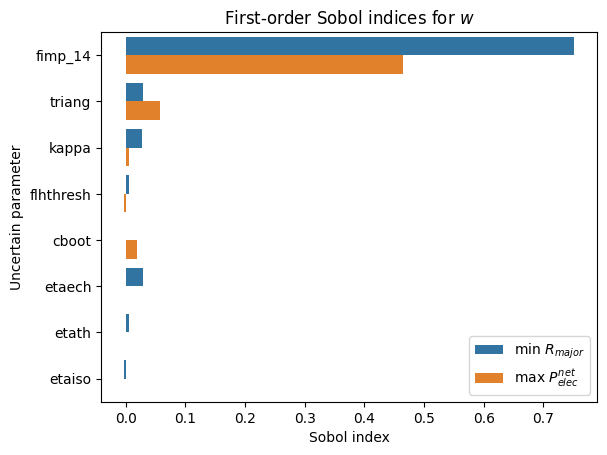

In [120]:
# Plot first orders for both designs
# Plotting single column: no need to melt
ax = sns.barplot(
    data=sobols_df,
    x="main",
    y="descriptor",
    hue="design",
    orient="h",
)
ax.set_title("First-order Sobol indices for $w$")
ax.set_xlabel("Sobol index")
ax.set_ylabel("Uncertain parameter")
label_map = {"lt": "min $R_{major}$", "lt_max_net_elec": "max $P_{elec}^{net}$"}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [label_map[l] for l in labels])

# Latex for uncertain params
# TODO Raises warning
# old_y_label_objs = [y_label_obj for y_label_obj in ax.get_yticklabels()]
# new_y_labels = []
# for old_y_label_obj in old_y_label_objs:
#     old_text = old_y_label_obj.get_text()
#     new_text = param_latex[old_text]
#     new_y_labels.append(new_text)

# ax.set_yticklabels(new_y_labels)

In [121]:
# Plot first and higher orders for both designs
# Need to plot multiple columns of data: melt
sobols_melted_df = sobols_df.melt(id_vars=["design", "descriptor", "latex_descriptor"])
# Only interested in main (first order) and higher order cols
sob_melt_mh_df = sobols_melted_df[sobols_melted_df["variable"].isin(["main", "higher"])]
sob_melt_mh_df

,design,descriptor,latex_descriptor,variable,value
0,lt,fimp_14,"$f_{imp, W}$",main,0.752084
1,lt,triang,$\delta_{sep}$,main,0.029458
2,lt,kappa,$\kappa_{sep}$,main,0.028144
3,lt,flhthresh,$f^{min}_{LH}$,main,0.005988
4,lt,cboot,$c_{BS}$,main,0.001458
5,lt,etaech,$n_{ECRH}$,main,0.028927
6,lt,etath,$\eta_{th}$,main,0.004883
7,lt,etaiso,$\eta_{iso}$,main,-0.001873
8,lt_max_net_elec,fimp_14,"$f_{imp, W}$",main,0.464746
9,lt_max_net_elec,triang,$\delta_{sep}$,main,0.058319


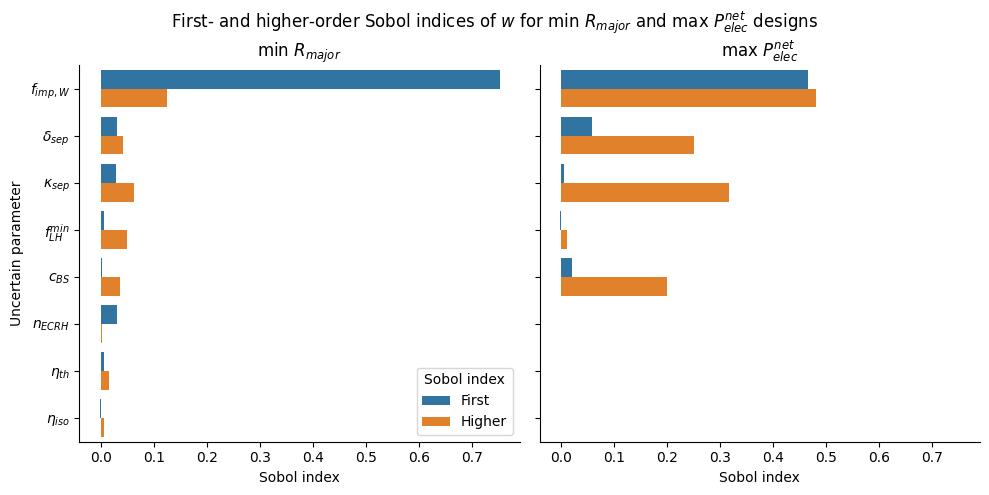

In [122]:
# Plot everything: both designs, first and higher Sobols, all unc params
fg = sns.catplot(
    data=sob_melt_mh_df,
    x="value",
    y="latex_descriptor",
    # y="descriptor",
    hue="variable",
    kind="bar",
    col="design",
    orient="h",
    legend_out=False,
)
# Move plots down slights to make room for suptitle
fg.figure.subplots_adjust(top=0.87)
fg.figure.suptitle(
    "First- and higher-order Sobol indices of $w$ for min $R_{major}$ and max $P_{elec}^{net}$ designs"
)
fg.set_axis_labels("Sobol index", "Uncertain parameter")
design_map = {"lt": "min $R_{major}$", "lt_max_net_elec": "max $P_{elec}^{net}$"}
fg.set_titles("{col_name}")
for ax in fg.axes.flatten():
    ax.set_title(design_map[ax.get_title()])

legend_map = {"main": "First", "higher": "Higher"}
fg.legend.set_title("Sobol index")
for legend_text in fg.legend.get_texts():
    legend_text.set_text(legend_map[legend_text.get_text()])